# Deep Learning with TensorFlow/Keras

Now that we have completed a project of Machine Learning with spark ML, in this assignment, we will be swithing to the context of Deep Learning with Tensorflow/Keras by two tasks:
- Task1: Image Classification with CNN
- Task2: Image captioning with a combination of CNN and RNN

## Task 1: Going Deeper with convolutions


Before **Inception v1** (**GoogLeNet**), which is the winner of the **ILSVRC** (ImageNet Large Scale Visual Recognition Competition) in 2014, most popular CNNs just stacked convolution layers deeper and deeper, hoping to get better performance.
The Inception network, however, uses a lot of tricks to improve performance in terms of speed and accuracy.
Compared to other networks, **Inception v1** has significant improvement over **ZFNet** (the winner in 2013) and **AlexNet** (the winner in 2012), and has relatively lower error rate compared with the VGGNet.

In this task, we will be implementing the inception architecture [in this paper](https://arxiv.org/abs/1409.4842) with TensorFlow/Keras. 

The goal of this task is to understand how to write code to build the model, as long as you can verify the correctness of the code (e.g., through Keras model summary), it is not necessary to train the model.

In [0]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


# Mount Drive for Data Persistence
The entire Flickr8k dataset has been uploaded on Drive and as well intermediate computation results are saved on Drive to be easily re-used and avoid to compute twice bottleneck step of the implentation, e.g. image preprocessing.

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
from tensorflow.keras import layers, utils, Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.models import model_from_json, load_model

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

import nltk
from nltk.translate.bleu_score import corpus_bleu

from pickle import dump
import pickle
from tqdm import tqdm
import string
import numpy as np
import random
from PIL import Image
import time
import os
from pathlib import Path

## Inception Module
![alt text](https://drive.google.com/uc?id=1DFa40hO7jJlX0QD0Nk82u-rtqmEbojy9)

In [0]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [0]:
kernel_init = tf.keras.initializers.glorot_uniform()
bias_init = tf.keras.initializers.Constant(value=0.2)

In [0]:
input_layer = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = layers.MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = layers.Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = layers.Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = layers.MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = layers.MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = layers.AveragePooling2D((5, 5), strides=3)(x)
x1 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(1024, activation='relu')(x1)
x1 = layers.Dropout(0.7)(x1)
x1 = layers.Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = layers.AveragePooling2D((5, 5), strides=3)(x)
x2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dense(1024, activation='relu')(x2)
x2 = layers.Dropout(0.7)(x2)
x2 = layers.Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = layers.MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = layers.GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(10, activation='softmax', name='output')(x)

In [0]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [0]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

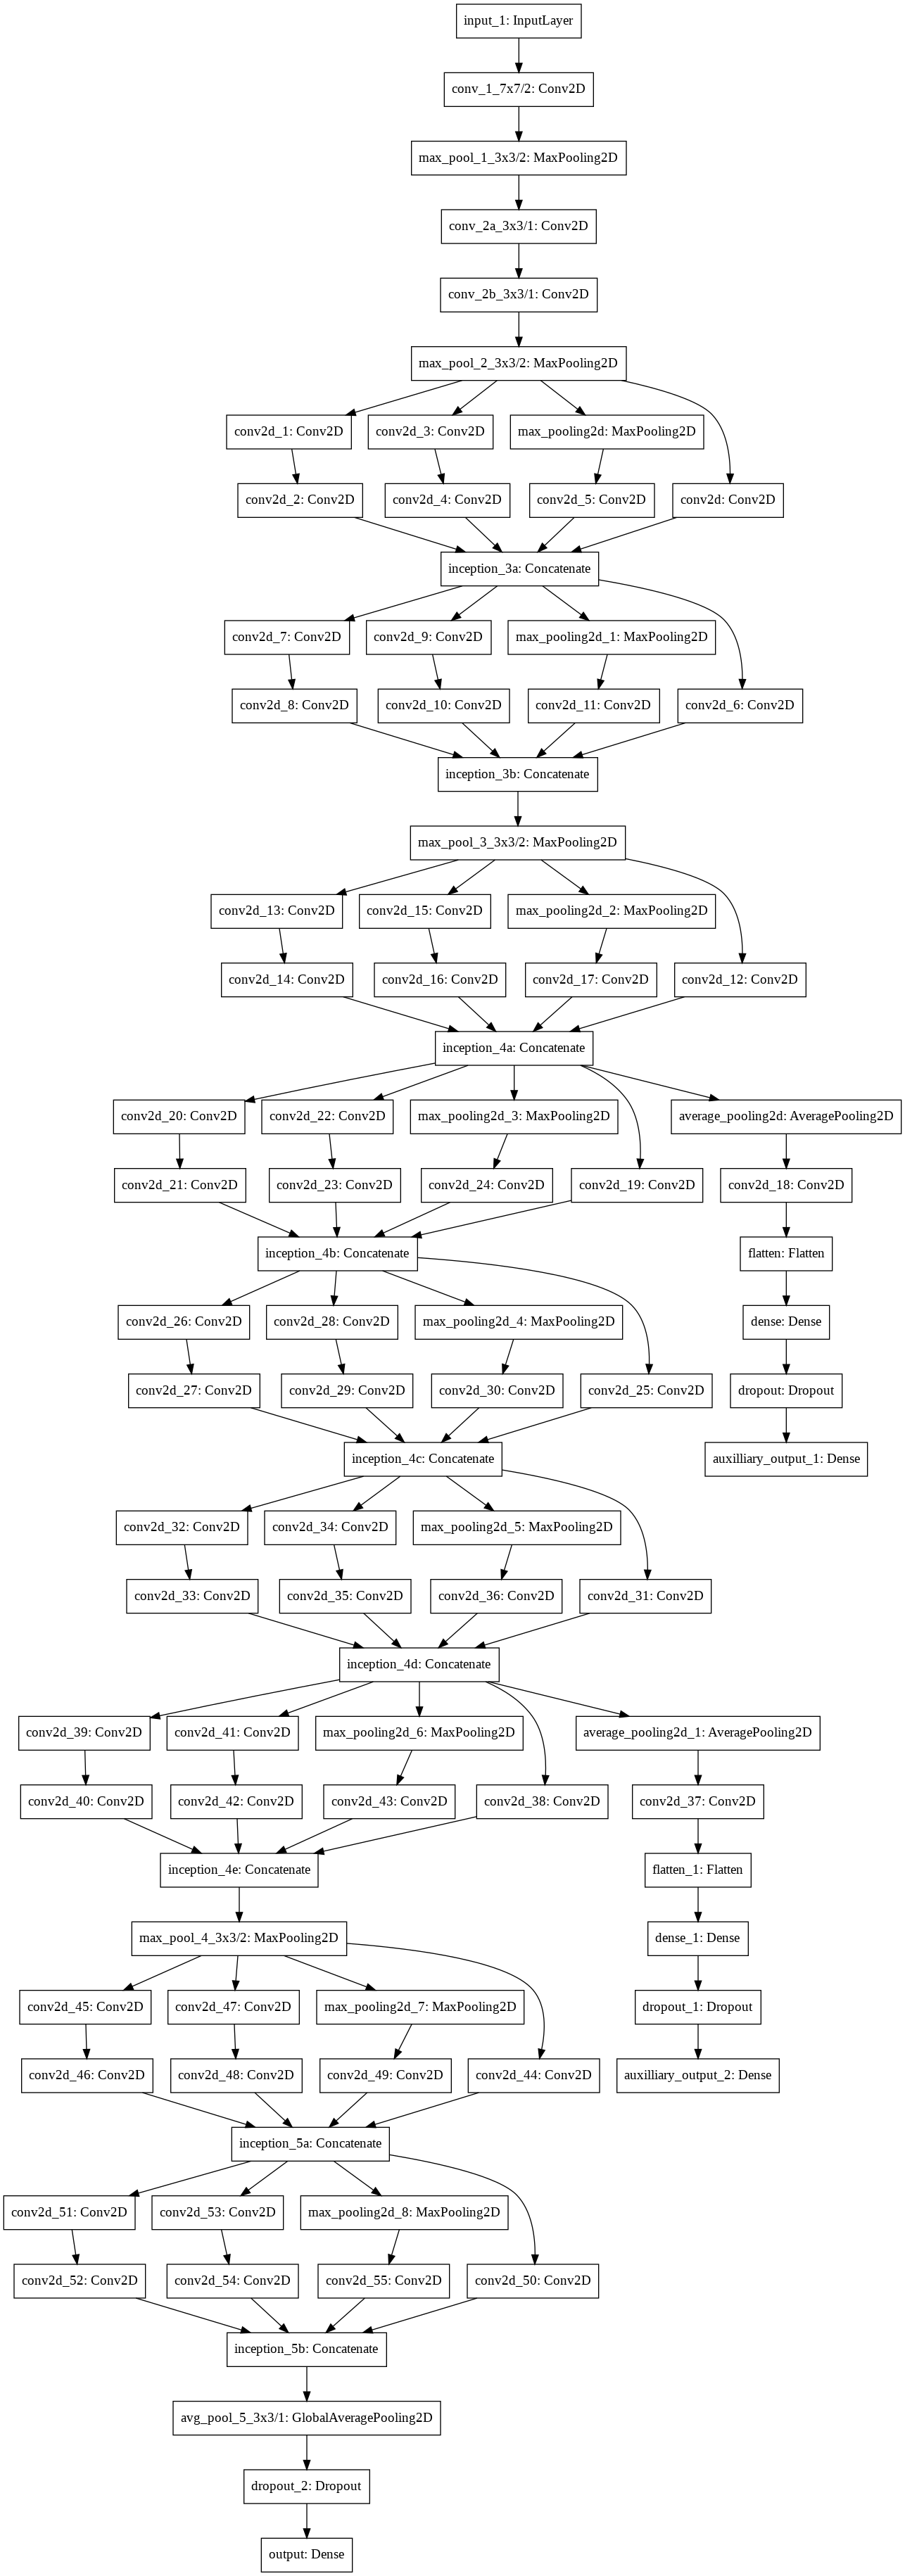

In [0]:
utils.plot_model(model)

## Task 2: Show and Tell: A Neural Image Caption Generator

Automatically describing the content of an image is a fundamental problem in AI that connects *computer vision* and *natural language processing*.
In this task, we will be looking into how we can use CNNs and RNNs to build an Image Caption Generator.

Specifically, you will be implementing and training the model [in this paper](https://arxiv.org/abs/1411.4555) with TensorFlow/Keras on one of the datasets mentioned in the paper.

To lighten the burden on training the network, you can use any pretrained network in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

# Model Inception V3 
In the Show and Tell paper, the authours proposed the usage of a CNN encoder, pre-trained for image classification task since CNNs can produce a rich representation of the input image by embedding it to a fixed-length vector.
The last hidden layer will be used as an input to the RNN decoder that generates sentences.
In this implementation we are going to use the pre-trained Inception v3 model available in tf.keras.applications as CNN encoder.


# Useful Paths


In [0]:
dirpath = "/content/drive/My Drive/Colab Notebooks/Flickr8"
modelpath = "/content/drive/My Drive/Colab Notebooks/Flickr8/Model"
procimgpath = "/content/drive/My Drive/Colab Notebooks/Flickr8/ProcessedImages" 
print(dirpath)

/content/drive/My Drive/Colab Notebooks/Flickr8


# CNN encoder
The CNN used to create a rich representation of the input image by embedding it to a fixed length vector is the Inception V3, whose weights are already available tf.keras.applications.

The documentation to properly use pre-trained model is available here:
https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes.

In [0]:
model = InceptionV3(weights='imagenet')
new_input = model.input
hidden_layer = model.layers[-2].output

final_model = Model(new_input, hidden_layer)

96116736/96112376 [==============================] - 1s 0us/step


# Images pre-processing: extracting feature vector from images
The dataset selected is Flickr8k, analyzed as well in the reference paper.

In the following code snippet we are going to prepare the input images in order to be processed.

in `trainImages.txt` we are going to find the picture file name, so that we will be able to load each image, extract their feature vector (using a pretrained model InceptionV3), and save them onto a dictionary.

In [0]:
#inception input image size format
TARGET_SIZE = (299,299)

def image_preprocessing(filepath):
  image_extracted = dict()
  with open(filepath) as f:
    data = f.read()
  
  try:
      for line in tqdm(data.split("\n")):
          if len(line) < 1:
            continue
          tokens = line.split(".")
          image_id = tokens[0]
          img = load_img(dirpath + "/Images/{}.jpg".format(image_id),target_size=TARGET_SIZE)
          
          # Converting image to array
          img_array = img_to_array(img)
          nimage = preprocess_input(img_array)
          
          # Adding one more dimension
          nimage = np.expand_dims(nimage, axis=0)

          # Creating the feature for my caption-detector, using the InceptionV3 model as feature extractor!    
          fea_vec = final_model.predict(nimage)
          image_extracted[image_id] = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )

  except Exception as e:
      print(e)
  
  f.close()
  return image_extracted

Since image pre-processing is a bottleneck we have already pre-processed images and saved them into:
- Training images: test_image_extracted.pkl
- Test images: train_image_extracted.pkl
- Validation images: val_image_extracted.pkl

If you need to proceed with the computation, decomment this cell:

In [0]:

train_image_extracted = image_preprocessing(dirpath + "/Flickr_8k.trainImages.txt")
# save file 
dump(train_image_extracted,open(procimgpath + "/train_image_extracted.pkl","wb"))


val_image_extracted = image_preprocessing(dirpath  + "/Flickr_8k.devImages.txt")
# save file 
dump(val_image_extracted,open(procimgpath + "/val_image_extracted.pkl","wb"))

test_image_extracted = image_preprocessing(dirpath + "/Flickr_8k.testImages.txt")
# save file 
dump(test_image_extracted,open(procimgpath + "/test_image_extracted.pkl","wb"))

'\ntrain_image_extracted = image_preprocessing(dirpath + "/Flickr_8k.trainImages.txt")\n# save file \ndump(train_image_extracted,open(procimgpath + "/train_image_extracted.pkl","wb"))\n\n\nval_image_extracted = image_preprocessing(dirpath  + "/Flickr_8k.devImages.txt")\n# save file \ndump(val_image_extracted,open(procimgpath + "/val_image_extracted.pkl","wb"))\n\ntest_image_extracted = image_preprocessing(dirpath + "/Flickr_8k.testImages.txt")\n# save file \ndump(test_image_extracted,open(procimgpath + "/test_image_extracted.pkl","wb"))\n'

# Dataset: Train, Validation and Test
The separation among train, validation and test has already been performed. Indeed, three different files contain the list of the images' filenames for train, validation and test.

In the following code snippet we are going to save these lists in order to be used later.

In [0]:
def load_set(filename):
    with open(filename) as f:
      doc = f.read()
    dataset = list()
    
    for line in doc.split('\n'):        
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)

    f.close()
    return (dataset)
 
train_filename = dirpath + "/Flickr_8k.trainImages.txt"
train = load_set(train_filename)
print('Train size: %d' % len(train))

val_filename = dirpath + "/Flickr_8k.devImages.txt"
validation = load_set(val_filename)
print('Validation size: %d' % len(validation))

test_filename = dirpath + "/Flickr_8k.testImages.txt"
test = load_set(test_filename)
print('Test size: %d' % len(test))

Train size: 6000
Validation size: 1000
Test size: 1000


# Captions Dictionary
Creation of the dictionary which contains image_id as a key and the list of captions as value

As we did for images, we will use the image filename as key for the dictionary

<image_id, list of 5 captions>

N.B. The captions need to be bounded by two special words to declare the beginning and the end of each caption, in the following line is provided an example.

`<startcap> example of a fake caption <endcap>`

In [0]:
# opening text file
with open(dirpath + "/Flickr8k.token.txt") as f:
    data = f.read()
	
# dictionary <image_id, list of 5 captions>
captions = dict()
max_cap_length = 0

rmpunc = str.maketrans('', '', string.punctuation)

try:
  for line in data.split("\n"):
    tokens = line.split()
    image_id , image_desc = tokens[0],tokens[1:]

    # dropping .jpg from image id
    image_id = image_id.split(".")[0]

    #caption to lower case and removal of punctuation
    image_desc = [word.lower() for word in image_desc]
    image_desc = [word.translate(rmpunc) for word in image_desc]
    image_desc = ' '.join(image_desc)

    desc = 'startcap ' + image_desc + ' endcap'
          
    if image_id not in captions:
      captions[image_id] = list()            
    captions[image_id].append(desc)
    
    if len(desc.split()) > max_cap_length:
      max_cap_length = len(desc.split())

except Exception as e:
  print(e)

f.close()
print("Example of captions of an image --> ")
print(next(iter(captions.values())))
print("Max sequence length %d" % max_cap_length)

Example of captions of an image --> 
['startcap a child in a pink dress is climbing up a set of stairs in an entry way  endcap', 'startcap a girl going into a wooden building  endcap', 'startcap a little girl climbing into a wooden playhouse  endcap', 'startcap a little girl climbing the stairs to her playhouse  endcap', 'startcap a little girl in a pink dress going into a wooden cabin  endcap']
Max sequence length 38


# Unique definition of the vocabulary dataset
Important to save the vocabulary and always use the same to save the model and perform prediction even in other sessions.

If you need to compute it, decomment the following cell_

In [0]:

def vocabulary(keys):
    vocabulary = set()
    for key in keys:
        [vocabulary.update(d.split()[1:len(d.split())-1]) for d in captions[key]]
    return list(vocabulary)

vocabulary = vocabulary(captions.keys())
print(vocabulary[:5])

with open(dirpath + "/vocabulary.pkl", "wb") as vocabulary_file:
     pickle.dump(vocabulary, vocabulary_file)

'\ndef vocabulary(keys):\n    vocabulary = set()\n    for key in keys:\n        [vocabulary.update(d.split()[1:len(d.split())-1]) for d in captions[key]]\n    return list(vocabulary)\n\nvocabulary = vocabulary(captions.keys())\nprint(vocabulary[:5])\n\nwith open(dirpath + "/vocabulary.pkl", "wb") as vocabulary_file:\n     pickle.dump(vocabulary, vocabulary_file)\n'

To check if the dataset has not been altered, we check that the first 5 words are:

['hurdles', 'seem', 'gathering', 'blindfolded', 'puck']

In [0]:
vocabulary = pickle.load(open(dirpath + '/vocabulary.pkl', 'rb'))
vocab_size = len(vocabulary) + 2 #consider startcap and endcap as well
print('Original Vocabulary Size: %d' % vocab_size)
vocabulary[:5]

Original Vocabulary Size: 8830


['hurdles', 'seem', 'gathering', 'blindfolded', 'puck']

# One hot encoding with dictionaries

In our task we will need to reason with words and the id they present, and with which the model will be reasoning in order to work. 

We compute 2 dictionaries

1. word to index is a dictionary which returns the index of the corresponding key-word

2. index to word is a dictionary which returns the word of the corresponding key-index 

In [0]:
ixtoword = dict()
wordtoix = dict()

ixtoword[0] = "startcap"
wordtoix["startcap"] = 0

ix = 1
for w in vocabulary:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

ixtoword[ix] = "endcap"
wordtoix["endcap"] = ix

print("The total words in the vocaboulary are", len(wordtoix))

The total words in the vocaboulary are 8830


# Data Generator

Input required by the model:
X_train: list of lists of elements s.t.:

X_train = [[Xtext1,Ximage1], [Xtext2,Ximage2], ...]

y_train: list of words: 

y_train= ["word1", "word2", ... ]

The word word1 is the one occurring after the Xtext1!

Where Xtext* is the sequence of words forming the caption. Note that we need to pass |words| possible datapoints train, and for each of them there will be a label y_train equal to the word to be predicted plus 1 (for predictiong the endseq)!

Example:
<Image_1_vector > "A dog is pooping" must be expressed as |A dog is pooping| = 4 samples points:

1. X_train = <Image_1_vector > "startseq" with label y_train = "A"
2. X_train = <Image_1_vector > "startseq A", with label y_train ="dog"
3. X_train = <Image_1_vector > "startseq A dog", with y_train =label "is"
4. X_train = <Image_1_vector > "startseq A dog is", with label y_train = "pooping"
5. X_train = <Image_1_vector > "startseq A dog is pooping", with label y_train = "endseq"



In [0]:
#Test caption encoding

for desc in next(iter(captions.values())):
  # encode the sequence
  print("Textual sequence:", desc)
  seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
  print("Encoded sequence:", seq)
  # split one sequence into multiple X, y pairs
  for i in range(1, len(seq)):
    # split into input and output pair
    in_seq, out_seq = seq[:i], seq[i]
    # pad input sequence
    in_seq = pad_sequences([in_seq], maxlen=max_cap_length,padding="post")[0]
    # encode output sequence
    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

print()
print("Input sequence encoded of length {} --> \n ".format(len(in_seq)), in_seq)
print("One hot encoding representation of the output word --> \nlen = {} | check_one only one = {}\n\n".format(len(out_seq),sum(out_seq)==1))

Textual sequence: startcap a child in a pink dress is climbing up a set of stairs in an entry way  endcap
Encoded sequence: [0, 2375, 3565, 5363, 2375, 5493, 2489, 3302, 791, 7757, 2375, 6135, 5527, 5556, 5363, 830, 128, 5801, 8829]
Textual sequence: startcap a girl going into a wooden building  endcap
Encoded sequence: [0, 2375, 6548, 5920, 8727, 2375, 7141, 7293, 8829]
Textual sequence: startcap a little girl climbing into a wooden playhouse  endcap
Encoded sequence: [0, 2375, 616, 6548, 791, 8727, 2375, 7141, 8644, 8829]
Textual sequence: startcap a little girl climbing the stairs to her playhouse  endcap
Encoded sequence: [0, 2375, 616, 6548, 791, 3714, 5556, 8045, 6457, 8644, 8829]
Textual sequence: startcap a little girl in a pink dress going into a wooden cabin  endcap
Encoded sequence: [0, 2375, 616, 6548, 5363, 2375, 5493, 2489, 5920, 8727, 2375, 7141, 6681, 8829]

Input sequence encoded of length 38 --> 
  [   0 2375  616 6548 5363 2375 5493 2489 5920 8727 2375 7141 6681    0

## Dataset

The Data Generator creates the dataset batch_size rows per time. It will be used to train on batches allowing the model not to use too much ram while training.



In [0]:
def data_generator(batch_size = 25, type="train"):

    if type=="train":
        keys = train
        train_image_extracted = pickle.load(open(procimgpath + '/train_image_extracted.pkl', 'rb'))
    elif type=="valid":
        keys = validation
        train_image_extracted = pickle.load(open(procimgpath + '/val_image_extracted.pkl', 'rb'))
    elif type=="test":
        keys = test
        train_image_extracted = pickle.load(open(procimgpath + '/test_image_extracted.pkl', 'rb'))
    else:
        print("Error: not existing type inserted")
        return -1

    Ximage_train, Xtext_train, ytext_train = list(), list(), list()
    n=0
    # loop for ever over images
    while(True):
      for key in tqdm(keys):
          cap_list = captions[key]
          # retrieve the photo feature
          photo = train_image_extracted[key]
          n+=1
          if(photo.shape != (2048,)):
              continue
          for desc in cap_list:
              # encode the sequence
              seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
              # split one sequence into multiple X, y pairs
              for i in range(1, len(seq)):
                  # split into input and output pair
                  in_seq, out_seq = seq[:i], seq[i]
                  # pad input sequence
                  in_seq = pad_sequences([in_seq], maxlen=max_cap_length,padding="post")[0]
                  # encode output sequence
                  out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                  # store
                  Ximage_train.append(photo)             
                  Xtext_train.append(in_seq)
                  ytext_train.append(out_seq)
                      
          # yield the batch data
          if n == batch_size:
              combined = list(zip(Ximage_train, Xtext_train, ytext_train))
              random.shuffle(combined)
              Ximage_train[:], Xtext_train[:], ytext_train[:] = zip(*combined)

              yield ([np.array(Ximage_train), np.array(Xtext_train)], np.array(ytext_train))
              Ximage_train, Xtext_train, ytext_train = list(), list(), list()
              n=0

In [0]:
def data_generator(batch_size = 25, type="train"):

    if type=="train":
        keys = train
        train_image_extracted = pickle.load(open(procimgpath + '/train_image_extracted.pkl', 'rb'))
    elif type=="valid":
        keys = validation
        train_image_extracted = pickle.load(open(procimgpath + '/val_image_extracted.pkl', 'rb'))
    elif type=="test":
        keys = test
        train_image_extracted = pickle.load(open(procimgpath + '/test_image_extracted.pkl', 'rb'))
    else:
        print("Error: not existing type inserted")
        return -1

    Ximage_train, Xtext_train, ytext_train = list(), list(), list()
    n=0
    # loop for ever over images
    for key in tqdm(keys):
          cap_list = captions[key]
          # retrieve the photo feature
          photo = train_image_extracted[key]
          n+=1
          if(photo.shape != (2048,)):
              continue
          for desc in cap_list:
              # encode the sequence
              seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
              # split one sequence into multiple X, y pairs
              for i in range(1, len(seq)):
                  # split into input and output pair
                  in_seq, out_seq = seq[:i], seq[i]
                  # pad input sequence
                  in_seq = pad_sequences([in_seq], maxlen=max_cap_length,padding="post")[0]
                  # encode output sequence
                  out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                  # store
                  Ximage_train.append(photo)             
                  Xtext_train.append(in_seq)
                  ytext_train.append(out_seq)
                      
          # yield the batch data
          if n == batch_size:
              combined = list(zip(Ximage_train, Xtext_train, ytext_train))
              random.shuffle(combined)
              Ximage_train[:], Xtext_train[:], ytext_train[:] = zip(*combined)

              yield ([np.array(Ximage_train), np.array(Xtext_train)], np.array(ytext_train))
              Ximage_train, Xtext_train, ytext_train = list(), list(), list()
              n=0

This is the script for the **Dataset creation** with normal training (no generator)

In [0]:
def get_dataset(type="train", size = 6000):
    # If size = >= 6000, get all 6000 pictures

    if type=="train":
        keys = train
        train_image_extracted = pickle.load(open(procimgpath + '/train_image_extracted.pkl', 'rb'))
    elif type=="valid":
        keys = validation
        train_image_extracted = pickle.load(open(procimgpath + '/val_image_extracted.pkl', 'rb'))
    elif type=="test":
        keys = test
        train_image_extracted = pickle.load(open(procimgpath + '/test_image_extracted.pkl', 'rb'))
    else:
        print("Error: not existing type inserted")
        return -1
  
    Ximage_train, Xtext_train, ytext_train = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key in tqdm(keys):
            cap_list = captions[key]
            # retrieve the photo feature
            photo = train_image_extracted[key]
            if(photo.shape != (2048,)):
              continue
            n+=1
            for desc in cap_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_cap_length,padding="post")[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    Ximage_train.append(photo)             
                    Xtext_train.append(in_seq)
                    ytext_train.append(out_seq)
                    
            if n == size:
            # yield the batch data
              return [[np.array(Ximage_train), np.array(Xtext_train)], np.array(ytext_train)]
            

## Parameters

We print and define some parameters.

In particular, dim_embedding is a parameter used to define the embeddings for the words and used to perform the captions. It is extremely important to tune this parameter to a reasonable value. We have selected 64 but it worked bad, here we proceed with value as 300.

In [0]:
# Parameters: 
print('Original Vocabulary Size: %d' % vocab_size)

## image feature
dim_embedding = 300
print('Embedding Size: %d' % dim_embedding)

train_image_extracted = pickle.load(open(procimgpath + '/train_image_extracted.pkl', 'rb'))
image_shape = train_image_extracted['2513260012_03d33305cf'].shape
print('Image pre-processed shape: ', image_shape)

maxlen = max_cap_length
max_len = max_cap_length
print('Maximum Length of caption: %d' % max_cap_length)

Original Vocabulary Size: 8830
Embedding Size: 300
Image pre-processed shape:  (2048,)
Maximum Length of caption: 38


# Model Creation and Fitting

We create the model and plot it.

We can find that the input is divided into 2 parts:

1. The Image features (taken from the InceptionV3 model
2. The Sequence words organized as ix (numbers). 

The model is explained in the paper suggested by the lab assignment, and has the goal to predict the most likely word to continue the sequence input. It is a sequence-to-vector model.

The output of the model instead is hence a vector of words with probabilities (Softmax of the vocaboulary size). We will select the word most likely to be chosen. However, many other ways exist to make the prediction (we will show them later)

In [0]:
def define_model(image_shape, maxlen, vocab_size):
  # Declare the input image with its shape and stack in a dense layer
  input_image = layers.Input(shape=image_shape)
  fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)

  ## Declare the input text (sequence of caption words) and stack in Embedding layer model and LSTM
  input_txt = layers.Input(shape=(maxlen,))
  ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
  ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
  ## combined model for decoder
  decoder = layers.add([ftxt,fimage])
  decoder = layers.Dense(256,activation='relu')(decoder)
  output = layers.Dense(vocab_size,activation='softmax')(decoder)
  model = Model(inputs=[input_image, input_txt],outputs=output)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  print(model.summary())
  utils.plot_model(model, to_file='model.png', show_shapes=True)

  return model

### Model with regularization

A model that has dropout between layers. We will use it later and explain about its usefulness

In [0]:
# The second model with regularization
def define_model_reg(image_shape, maxlen, vocab_size, dropout_rate=0.5):
		# feature extractor model
		inputs1 = Input(shape=(image_shape))
		fe1 = Dropout(dropout_rate)(inputs1)
		fe2 = Dense(256, activation='relu')(fe1)
	
		# sequence model
		inputs2 = Input(shape=(maxlen,))
		se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
		se2 = Dropout(dropout_rate)(se1)
		se3 = LSTM(256)(se2)
	
		# decoder model
		decoder1 = layers.add([fe2, se3])
		decoder2 = Dense(256, activation='relu')(decoder1)
		outputs = Dense(vocab_size, activation='softmax')(decoder2)
		# tie it together [image, seq] [word]
		model = Model(inputs=[inputs1, inputs2], outputs=outputs)
		model.compile(loss='categorical_crossentropy', optimizer='adam')
		return model


## Introducting a model with Bidirectional layer

A Bidirectional layer csan help with the vanishing gradient problem. Is actually a double-LSTM layer when inputs are given as the following:
- input sequence as-is as input to the first layer 
- providing a reversed copy of the input sequence to the second.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 256)      2260480     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

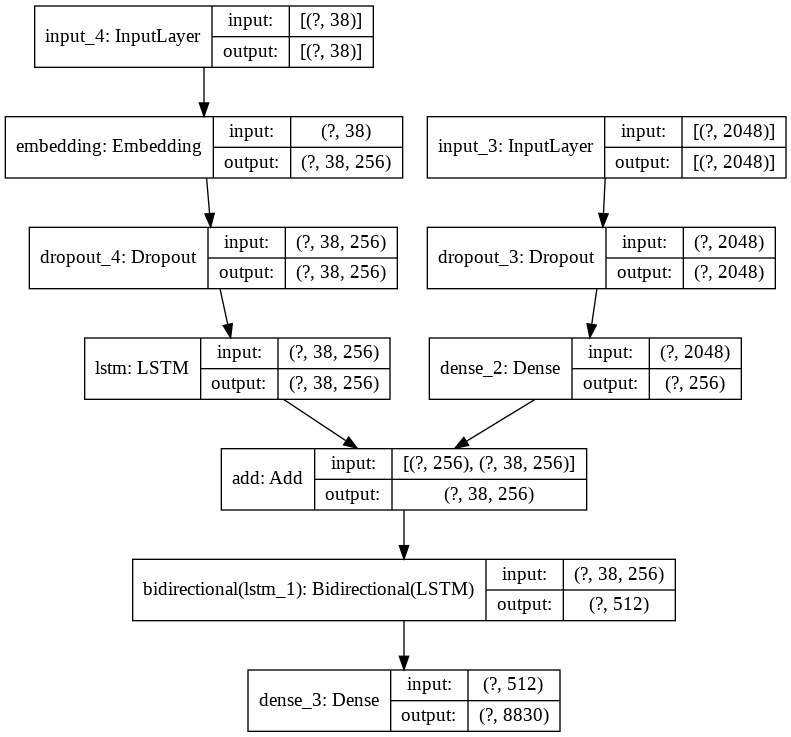

In [0]:
# The second model with regularization
def define_model_reg_bidi(image_shape, maxlen, vocab_size, dropout_rate=0.5):
    # feature extractor model
    inputs1 = Input(shape=(image_shape))
    fe1 = Dropout(dropout_rate)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(maxlen,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(dropout_rate)(se1)
    se3 = LSTM(256,return_sequences=True)(se2)

    #decoder model
    decoder1 = layers.add([fe2, se3])
    decoder2 = Bidirectional(LSTM(256, return_sequences=False))(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
  
  # summarize model

model = define_model_reg_bidi(image_shape, maxlen, vocab_size, dropout_rate=0.5)
print(model.summary())
utils.plot_model(model, to_file='reg_model.png', show_shapes=True)

# Training the model
Thi step is a bottleneck, here we are going to show the code snippet used to train it, but for the prediction we are importing the weights of the model already trained

In [0]:
"""
# train the model, run epochs manually and save after each epoch
epochs = 20
steps_train = 60
steps_val = 10
batch_size = 100
print("Is steps*batch_size equal to total samples num?", steps_train * batch_size == len(train))
print("Is steps*batch_size equal to total samples num?", steps_val * batch_size == len(validation))

for i in range(epochs):
    # create the data generator
    generator = data_generator(batch_size = batch_size)
    # create the data generator for the validation
    val_generator = data_generator(batch_size = batch_size, type="valid")

    # fit for one epoch
    model.fit(generator, steps_per_epoch = steps_train, epochs = 1, verbose=2)
    # evaluate
    model.evaluate_generator(val_generator, steps = steps_val, verbose = 2)
    

    # save model
    #When saving to disk is recommended to save the model architecture as json and the weights as .h5
    #in two distinct files
    model_json = model.to_json()
    with open(modelpath + '/modelBB_arch_epoch_{}.json'.format(i+1),'w') as json_file:
        json_file.write(model_json)
    #save weights
    model.save_weights(modelpath + '/modelBB_weights_epoch_{}.h5'.format(i+1))
  """

'\n# train the model, run epochs manually and save after each epoch\nepochs = 20\nsteps_train = 60\nsteps_val = 10\nbatch_size = 100\nprint("Is steps*batch_size equal to total samples num?", steps_train * batch_size == len(train))\nprint("Is steps*batch_size equal to total samples num?", steps_val * batch_size == len(validation))\n\nfor i in range(epochs):\n    # create the data generator\n    generator = data_generator(batch_size = batch_size)\n    # create the data generator for the validation\n    val_generator = data_generator(batch_size = batch_size, type="valid")\n\n    # fit for one epoch\n    model.fit(generator, steps_per_epoch = steps_train, epochs = 1, verbose=2)\n    # evaluate\n    model.evaluate_generator(val_generator, steps = steps_val, verbose = 2)\n    \n\n    # save model\n    #When saving to disk is recommended to save the model architecture as json and the weights as .h5\n    #in two distinct files\n    model_json = model.to_json()\n    with open(modelpath + \'/mod

Here we train the regularized model using define_model_reg().

We have tried to use the non-regularized model, however, the predictions looked very bad.

# Importing model and weights 

We have already trained some models and saved their weights. Here we load them avoiding to waste time to training the model. (If want, decomment the cell above)

In [0]:
epochs = 20
with open(modelpath + '/model_arch_epoch_{}.json'.format(epochs),'r') as json_file:
    new_model = model_from_json(json_file.read())
new_model.load_weights(modelpath + '/model_weights_epoch_{}.h5'.format(epochs))
new_model.compile(loss='categorical_crossentropy', optimizer='adam')

# To Check if the model is correctly imported it is possible to evaluate the model again
"""
val_generator = data_generator(batch_size = 100)
new_model.evaluate_generator(val_generator, steps = steps_val, verbose = 0)
"""

'\nval_generator = data_generator(batch_size = 100)\nnew_model.evaluate_generator(val_generator, steps = steps_val, verbose = 0)\n'

# Prediction time

In this notebook we will show 2 methods for prediction of the caption:

1. **Greedy Prediction** (given a startcap and picture, predict one after one the following words for the captioning
2. **Beam search prediction** (take the first k most likely words in the sequential prediction of the caption, and in the end get the sequence most likely true

In evaluating the captions of pictures, it is possible to use accuracy as the number of words predicted correct over the number of total correctwords.  However,  this approach makes bad evaluation 

Instead, we can use the BLEU score, used already for translation evaluation, and in general used for other language generation problems with deep learning methods such as:

Language generation.
**Image caption generation**.
Text summarization.
Speech recognition.


- First: given a test photo, retrieve its captions (we have 5 catpions in Flixkr8)
- Second: generate the prediction-caption given the test photo.
- Third: evaluate using BLEU


In [0]:
images_extracted_feat = {}
images_extracted_feat.update(pickle.load(open(procimgpath + '/train_image_extracted.pkl', 'rb')))
images_extracted_feat.update(pickle.load(open(procimgpath + '/val_image_extracted.pkl', 'rb')))
images_extracted_feat.update(pickle.load(open(procimgpath + '/test_image_extracted.pkl', 'rb')))
print("Done")

Done


## Final Prediction using BLEU Score

We will evaluate for every n-gram and the weighted uniformly version of n-grams up to 4

In [0]:
def evaluate_model_predict(model, captions, keys, mode="beam", beam_index=3):
  actual, predicted = list(), list()
  # step over the whole set
  for key in tqdm(keys):
    # generate description
    captions_true = captions[key]

    if mode == "beam":
      predicted_cap = beam_search_predictions(model, key, beam_index=beam_index)
    else:
      predicted_cap = greedy_predictions(model, key)

    # store actual and predicted
    references = [d.split() for d in captions_true]
    actual.append(references)
    predicted.append(predicted_cap.split())

  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  print("\n\nEvaluation on single n-grams:\n\n")
  print('Individual 1-gram: %f' % corpus_bleu(actual, predicted, weights=(1, 0, 0, 0)))
  print('Individual 2-gram: %f' % corpus_bleu(actual, predicted, weights=(0, 1, 0, 0)))
  print('Individual 3-gram: %f' % corpus_bleu(actual, predicted, weights=(0, 0, 1, 0)))
  print('Individual 4-gram: %f' % corpus_bleu(actual, predicted, weights=(0, 0, 0, 1)))

## 1- Greedy Prediction

In [0]:
def greedy_predictions(model, key_pic):

    # retrieve the photo feature
    photo = images_extracted_feat[key_pic]

    sequence = ["startcap"] #first word is startcap
    #in_seq = [0] #startcap correspond to 0 in the one hot encoding
    last_word = "startcap"


    # go until we predict the end of the sequence
    while last_word != "endcap" and len(sequence) < max_cap_length:
      in_seq = [wordtoix[i] for i in sequence]
      in_seq = pad_sequences([in_seq], maxlen=max_cap_length, padding="post")[0]
      
      yhat = model.predict((np.array([photo]) ,np.array([in_seq])), verbose=0)

      yhat = np.argmax(yhat[0]) #get the first element predicted
      word = ixtoword[yhat]

      if word is None or word == "endcap":
        break
      sequence.append(word)
      # append as input for generating the next word

      last_word = word

    return ' '.join(sequence[1:])


In [0]:
# generate a description for an image
def generate_desc(model, key_pic):
    cap_list = captions[key_pic]
    # retrieve the photo feature
    photo = images_extracted_feat[key_pic]

    sequence = "startcap" #first word is startcap
    in_seq = [0]
    last_word = "startcap"


    # go until we predict the end of the sequence
    while last_word != "endcap":

      in_seq = pad_sequences([in_seq], maxlen=max_cap_length, padding="post")[0]
      
      yhat = model.predict((np.array([photo]) ,np.array([in_seq])), verbose=0)

      yhat = np.argmax(yhat)
      word = ixtoword[yhat]

      if word is None:
        break
      sequence += " "
      # append as input for generating the next word
      sequence += word
      in_seq += yhat

      last_word = word

    return sequence


## Evaluate as greedy


In [0]:
evaluate_model_predict(new_model, captions, test, mode="greedy")

BLEU-1: 0.433417
BLEU-2: 0.229972
BLEU-3: 0.145078
BLEU-4: 0.060817


Evaluation on single n-grams:


Individual 1-gram: 0.433417
Individual 2-gram: 0.122024
Individual 3-gram: 0.030338
Individual 4-gram: 0.008526


## 2- Beam Search Prediction

In [0]:
def beam_search_predictions(model, key_pic, beam_index = 3):
    start = [wordtoix["startcap"]]
    
    start_word = [[start, 0.0]]

    photo = images_extracted_feat[key_pic]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_len, padding='post')[0]

            preds = model.predict([ np.array([photo]), np.array([par_caps]) ])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endcap':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

### Evaluate with the beam pred

In [0]:
evaluate_model_predict(new_model, captions, test, mode="beam", 3)

BLEU-1: 0.427124
BLEU-2: 0.228221
BLEU-3: 0.148967
BLEU-4: 0.066752


Evaluation on single n-grams:


Individual 1-gram: 0.427124
Individual 2-gram: 0.121943
Individual 3-gram: 0.033944
Individual 4-gram: 0.011230


## Comment on results

It seems that both beam prediction and greedy prediction shows very similar results.

It is possible to notice that larget n-grams seems to have slightly higher score when using beam prediction.
Instead, Greedy prediction performs better in single n-gram.

## Prediction and Caption Comparison

Let's visualize some of the predicted captions

Picture:  256085101_2c2617c5d0
Normal Max search: two dogs are playing with a ball
Beam Search, k=3: three dogs are playing with a stick
Beam Search, k=5: there is a black and white dog in the snow
Beam Search, k=7: there is a black and white dog in the snow


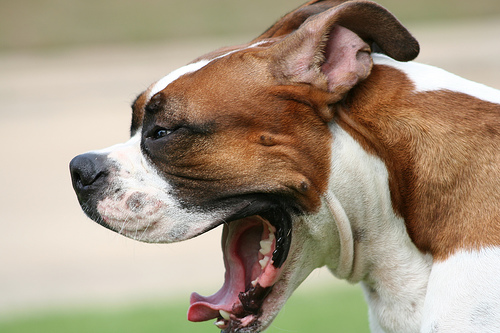

In [0]:
image_key = "256085101_2c2617c5d0"

print("Picture: ", image_key)
print ('Normal Max search:', greedy_predictions(new_model, image_key)) 
print ('Beam Search, k=3:', beam_search_predictions(new_model, image_key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(new_model, image_key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(new_model, image_key, beam_index=7))

Image.open(dirpath + "/Images/{}.jpg".format(image_key))

## Some problems: 

Sometimes the model is predicting and repeating multiple times the same words. 

Let's see i.e. with this picture:

Picture:  3727752439_907795603b
Normal Max search: two girls in a red shirt and a blue shirt with a blue shirt
Beam Search, k=3: a woman in a blue shirt is standing on a wall with a red bag
Beam Search, k=5: there is a woman in a blue shirt and white shirt is standing on a cellphone
Beam Search, k=7: there is a woman in a blue shirt and white shirt is standing on a cellphone


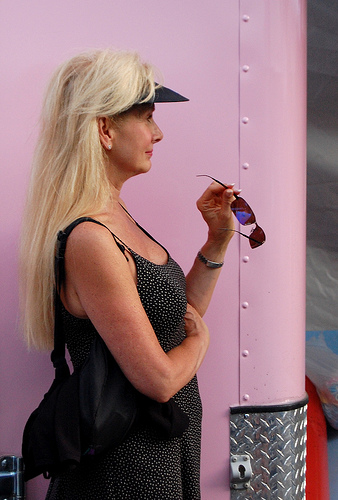

In [0]:
key = "3727752439_907795603b"

print("Picture: ", key)
print ('Normal Max search:', greedy_predictions(new_model, key)) 
print ('Beam Search, k=3:', beam_search_predictions(new_model, key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(new_model, key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(new_model, key, beam_index=7))

Image.open(dirpath + "/Images/{}.jpg".format(key))

### **Possible Solution:**
We can perform an analysis of the sequence during the prediction and before choosing the most likely word, **put at zero** the scores probabilities of those words (or better, the n-grams already present in the sentence).

For this project, we will only implement a version that avoids to consider already predicted words. However, a more accurate job would be done rolling-back whenever it is predicted that a 2-gram is repeated over the sequence.

It would be done for future work.

In [0]:
# Import stopwords (of course, we will avoid stopwords for our filter)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def greedy_predictions_corr(model, key_pic):

    # retrieve the photo feature
    photo = images_extracted_feat[key_pic]

    sequence = ["startcap"] #first word is startcap
    #in_seq = [0] #startcap correspond to 0 in the one hot encoding
    last_word = "startcap"


    # go until we predict the end of the sequence
    while last_word != "endcap" and len(sequence) < max_cap_length:
      in_seq = [wordtoix[i] for i in sequence]
      in_seq = pad_sequences([in_seq], maxlen=max_cap_length, padding="post")[0]
      
      yhat = model.predict((np.array([photo]) ,np.array([in_seq])), verbose=0)

      # put at 0 the repeated predictions:
      repeated = sequence
      relevant = set(repeated) - stop_words
      rel_ix = [wordtoix[i] for i in relevant]

      yhat = yhat[0]
      for ix in rel_ix:
        yhat[ix] = 0

      yhat = np.argmax(yhat) #get the first element predicted
      word = ixtoword[yhat]

      if word is None or word == "endcap":
        break
      sequence.append(word)
      # append as input for generating the next word

      last_word = word

    return ' '.join(sequence[1:])

In [0]:
def beam_search_predictions_corr(model, key_pic, beam_index = 3):
    start = [wordtoix["startcap"]]
    
    start_word = [[start, 0.0]]

    photo = images_extracted_feat[key_pic]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_len, padding='post')[0]

            preds = model.predict([ np.array([photo]), np.array([par_caps]) ])

            # put at 0 the repeated predictions:
            repeated = set([ixtoword[x] for x in s[0]])

            relevant = set(repeated) - stop_words
            rel_ix = [wordtoix[i] for i in relevant]

            yhat = preds[0]
            for ix in rel_ix:
              yhat[ix] = 0
            
            word_preds = np.argsort(yhat)[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endcap':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

See how it performs:

In [0]:
interesting_keys = ['3727752439_907795603b', "3502343542_f9b46688e5", '2295750198_6d152d7ceb', '3222055946_45f7293bb2']

In [0]:
key = interesting_keys[0]

print("Picture: ", key)
print ('Normal Max search:', greedy_predictions(new_model, key)) 
print ('Beam Search, k=3:', beam_search_predictions(new_model, key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(new_model, key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(new_model, key, beam_index=7))

Picture:  3727752439_907795603b
Normal Max search: two girls in a red shirt and a blue shirt with a blue shirt
Beam Search, k=3: a woman in a blue shirt is standing on a wall with a red bag
Beam Search, k=5: there is a woman in a blue shirt and white shirt is standing on a cellphone
Beam Search, k=7: there is a woman in a blue shirt and white shirt is standing on a cellphone


Picture:  3727752439_907795603b
Normal Max search: two girls in a red shirt and a blue cap with a black and white mask
Beam Search, k=3: a woman in a blue shirt is standing on a wall with a tattoo of her hand
Beam Search, k=5: there is a woman in a red shirt and a blue cap is standing on a cellphone
Beam Search, k=7: there is a woman in a red shirt and a blue cap is standing on a cellphone


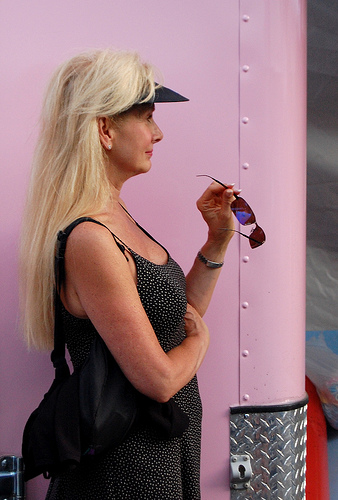

In [0]:
print("Picture: ", key)
print ('Normal Max search:', greedy_predictions_corr(new_model, key)) 
print ('Beam Search, k=3:', beam_search_predictions_corr(new_model, key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions_corr(new_model, key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions_corr(new_model, key, beam_index=7))

Image.open(dirpath + "/Images/{}.jpg".format(key))

In [0]:
key = interesting_keys[1]

print("Picture: ", key)
print ('Normal Max search:', greedy_predictions(new_model, key)) 
print ('Beam Search, k=3:', beam_search_predictions(new_model, key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(new_model, key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(new_model, key, beam_index=7))

Picture:  3502343542_f9b46688e5
Normal Max search: two people climbing a rock face
Beam Search, k=3: two people climbing a rock face
Beam Search, k=5: two people climbing a rock face
Beam Search, k=7: two people climbing a rock face


Picture:  3502343542_f9b46688e5
Normal Max search: two people climbing a rock face
Beam Search, k=3: two people climbing a rock face
Beam Search, k=5: there is a man climbs a rock wall
Beam Search, k=7: there is a man climbs a rock wall


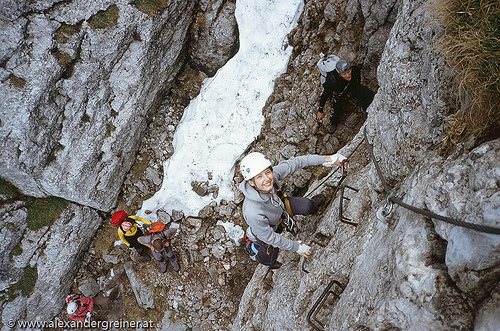

In [0]:
print("Picture: ", key)
print ('Normal Max search:', greedy_predictions_corr(new_model, key)) 
print ('Beam Search, k=3:', beam_search_predictions_corr(new_model, key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions_corr(new_model, key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions_corr(new_model, key, beam_index=7))

Image.open(dirpath + "/Images/{}.jpg".format(key))

In [0]:
key = interesting_keys[2]

print("Picture: ", key)
print ('Normal Max search:', greedy_predictions(new_model, key)) 
print ('Beam Search, k=3:', beam_search_predictions(new_model, key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(new_model, key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(new_model, key, beam_index=7))

Picture:  2295750198_6d152d7ceb
Normal Max search: a woman in a blue shirt and blue jacket walking on a wooded trail
Beam Search, k=3: three people are playing on a park
Beam Search, k=5: three people are playing next along a park road
Beam Search, k=7: three people are playing next along a park road


Picture:  2295750198_6d152d7ceb
Normal Max search: a woman in a blue shirt and white jacket walking on a park road
Beam Search, k=3: three people are playing on a park road
Beam Search, k=5: three people are playing on a park road
Beam Search, k=7: three people are playing on a wooded road in the field


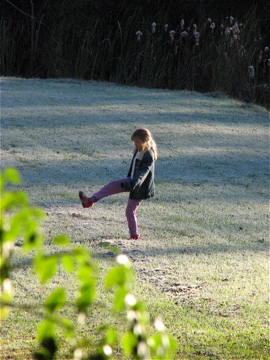

In [0]:
print("Picture: ", key)
print ('Normal Max search:', greedy_predictions_corr(new_model, key)) 
print ('Beam Search, k=3:', beam_search_predictions_corr(new_model, key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions_corr(new_model, key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions_corr(new_model, key, beam_index=7))

Image.open(dirpath + "/Images/{}.jpg".format(key))

In [0]:
key = interesting_keys[3]

print("Picture: ", key)
print ('Normal Max search:', greedy_predictions(new_model, key)) 
print ('Beam Search, k=3:', beam_search_predictions(new_model, key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(new_model, key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(new_model, key, beam_index=7))

Picture:  3222055946_45f7293bb2
Normal Max search: a man in black and white jacket and an yellow jacket is running to the floor
Beam Search, k=3: a man in black and white collar jacket with an rainy ball
Beam Search, k=5: a boy wearing a red jacket is videotaping a ball
Beam Search, k=7: a few girls with the tripod is looking at the mountains


Picture:  3222055946_45f7293bb2
Normal Max search: a man in black and white jacket and an yellow ball while the wall
Beam Search, k=3: a man in black and white collar jacket with an rainy ball
Beam Search, k=5: a boy wearing a muzzle and black pants ready to his finger while walking on a bench
Beam Search, k=7: a boy wearing a muzzle and black pants ready to the finger


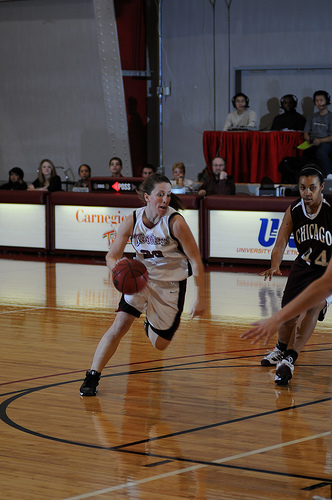

In [0]:
print("Picture: ", key)
print ('Normal Max search:', greedy_predictions_corr(new_model, key)) 
print ('Beam Search, k=3:', beam_search_predictions_corr(new_model, key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions_corr(new_model, key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions_corr(new_model, key, beam_index=7))

Image.open(dirpath + "/Images/{}.jpg".format(key))

## Results:
The correction works, however, we notice that the beam search behaves differently than the greeedy prediction in that way.

This is given by the fact that in beam prediction we are evaluating k different captions, and putting at zero certain words, we are decreasing the cumulative probability of that caption, that might not be the most likely (i.e. the caption startign with "a boy" comes first in the second key).

### Let's now provide an evaluation with the BEAM metrics:

In [0]:
def evaluate_model_predict_corr(model, captions, keys, mode="beam", beam_index=3):
  actual, predicted = list(), list()
  # step over the whole set
  for key in tqdm(keys):
    # generate description
    captions_true = captions[key]

    if mode == "beam":
      predicted_cap = beam_search_predictions_corr(model, key, beam_index=beam_index)
    else:
      predicted_cap = greedy_predictions_corr(model, key)

    # store actual and predicted
    references = [d.split() for d in captions_true]
    actual.append(references)
    predicted.append(predicted_cap.split())

  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  print("\n\nEvaluation on single n-grams:\n\n")
  print('Individual 1-gram: %f' % corpus_bleu(actual, predicted, weights=(1, 0, 0, 0)))
  print('Individual 2-gram: %f' % corpus_bleu(actual, predicted, weights=(0, 1, 0, 0)))
  print('Individual 3-gram: %f' % corpus_bleu(actual, predicted, weights=(0, 0, 1, 0)))
  print('Individual 4-gram: %f' % corpus_bleu(actual, predicted, weights=(0, 0, 0, 1)))

(old scores=)

BLEU-1: 0.433417\
BLEU-2: 0.229972\
BLEU-3: 0.145078\
BLEU-4: 0.060817

Evaluation on single n-grams:

Individual 1-gram: 0.433417\
Individual 2-gram: 0.122024\
Individual 3-gram: 0.030338\
Individual 4-gram: 0.008526\

In [0]:
evaluate_model_predict_corr(new_model, captions, test, mode="greedy")

100%|██████████| 1000/1000 [08:35<00:00,  2.19it/s]


BLEU-1: 0.438804
BLEU-2: 0.232785
BLEU-3: 0.145768
BLEU-4: 0.061047


Evaluation on single n-grams:


Individual 1-gram: 0.438804
Individual 2-gram: 0.123492
Individual 3-gram: 0.030082
Individual 4-gram: 0.008520


-----------

Old Beam Scores:

BLEU-1: 0.427124\
BLEU-2: 0.228221\
BLEU-3: 0.148967\
BLEU-4: 0.066752

Evaluation on single n-grams:

Individual 1-gram: 0.427124\
Individual 2-gram: 0.121943\
Individual 3-gram: 0.033944\
Individual 4-gram: 0.011230

In [0]:
evaluate_model_predict_corr(new_model, captions, test, mode="beam")

100%|██████████| 1000/1000 [1:05:34<00:00,  3.87s/it]


BLEU-1: 0.419878
BLEU-2: 0.223480
BLEU-3: 0.146258
BLEU-4: 0.065493


Evaluation on single n-grams:


Individual 1-gram: 0.419878
Individual 2-gram: 0.118948
Individual 3-gram: 0.033006
Individual 4-gram: 0.011161


## As expected, different results

In Greedy prediction we have a slightly better result than with the non corrected version!

Instead, in Beam the metric drops a bitm following what we have discussed in the cells above.

In [0]:
#evaluate_model_predict_corr(new_model, captions, validation, mode="greedy")

In [0]:
#evaluate_model_predict(new_model, captions, validation, mode="beam")

# Results with model containing a Bidirectional

A Biirectional layer can help with the vanishing gradient problem. Is actually a double-LSTM layer when inputs are given as the following:
- input sequence as-is as input to the first layer 
- providing a reversed copy of the input sequence to the second.

It should improve the results. Let's see


Oss. we have already trained it. Here we just import the weights

In [0]:
epochs = 20
with open(modelpath + '/modelBB_arch_epoch_{}.json'.format(epochs),'r') as json_file:
    new_model = model_from_json(json_file.read())
new_model.load_weights(modelpath + '/modelBB_weights_epoch_{}.h5'.format(epochs))
new_model.compile(loss='categorical_crossentropy', optimizer='adam')

# To Check if the model is correctly imported it is possible to evaluate the model again
"""
val_generator = data_generator(batch_size = 100)
new_model.evaluate_generator(val_generator, steps = steps_val, verbose = 0)
"""

In [0]:
evaluate_model_predict(new_model, captions, test, mode="greedy")

100%|██████████| 1000/1000 [06:33<00:00,  2.90it/s]


BLEU-1: 0.387459
BLEU-2: 0.252928
BLEU-3: 0.183419
BLEU-4: 0.090885


Evaluation on single n-grams:


Individual 1-gram: 0.387459
Individual 2-gram: 0.165108
Individual 3-gram: 0.058184
Individual 4-gram: 0.018331


In [0]:
evaluate_model_predict(new_model, captions, test, mode="greedy")

## Very surprisingly the BLEU score is lower.
** However, if we compare the captions.. **

We see that the high order BLEU scores (2+) are better than using the normal model. 


Looking at the captions, instead, the model with bidirectional looks much more reasonable! Let's i.e. compare the predictions for the picture of the little girl in the grass and of the basketball player. ONLY THIS MODEL is able to understan that the subject is respectively a girl and a basketball player!

Picture:  2295750198_6d152d7ceb
Normal Max search: two girls are running through a field
Beam Search, k=3: a young girl in a red shirt is running through a field
Beam Search, k=5: there is a girl in a red shirt is running through the grass
Beam Search, k=7: there is a girl in a red shirt is running through the grass


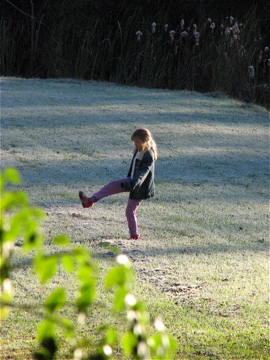

In [0]:
key = interesting_keys[2]

print("Picture: ", key)
print ('Normal Max search:', greedy_predictions(new_model, key)) 
print ('Beam Search, k=3:', beam_search_predictions(new_model, key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(new_model, key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(new_model, key, beam_index=7))

Image.open(dirpath + "/Images/{}.jpg".format(key))

Picture:  3222055946_45f7293bb2
Normal Max search: two basketball players are playing basketball
Beam Search, k=3: a basketball player dribbles the ball
Beam Search, k=5: a basketball player playing basketball
Beam Search, k=7: a basketball player playing basketball


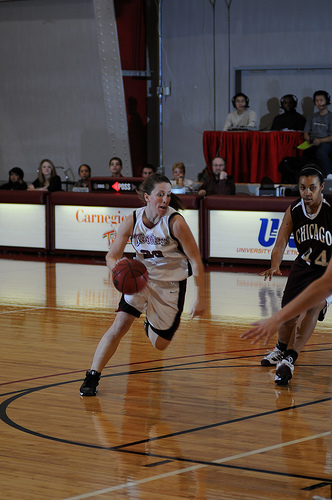

In [0]:
key = interesting_keys[3]

print("Picture: ", key)
print ('Normal Max search:', greedy_predictions(new_model, key)) 
print ('Beam Search, k=3:', beam_search_predictions(new_model, key, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(new_model, key, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(new_model, key, beam_index=7))

Image.open(dirpath + "/Images/{}.jpg".format(key))